In [1]:
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn,utils 
import mxnet.ndarray as F
import numpy as np
import os, sys
from tqdm import tqdm
import pickle
import random
from tqdm import tnrange, tqdm_notebook

In [2]:
mx.__version__

'1.2.0'

In [3]:
##generate input data
!python sort_of_clevr_gen.py

directory ./data already exists
building test datasets...
building train datasets...
saving datasets...
datasets saved at ./data/sort-of-clevr.pickle


In [4]:
GPU_COUNT = 2 # Set gpu count
def setting_ctx(GPU_COUNT):
    if GPU_COUNT > 0 :
        ctx = [mx.gpu(i) for i in range(GPU_COUNT)]
    else :
        ctx = [mx.cpu()]
    return ctx
        
ctx = setting_ctx(GPU_COUNT)

In [5]:
class ConvInputModel(nn.HybridBlock):
    def __init__(self,**kwargs):
        super(ConvInputModel,self).__init__(**kwargs)
                
        with self.name_scope():
            self.conv1 = nn.Conv2D(channels=24,kernel_size=3,strides=2,padding=1,activation='relu')
            self.bn1 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels=24,kernel_size=3,strides=2,padding=1,activation='relu')
            self.bn2 = nn.BatchNorm()
            self.conv3 = nn.Conv2D(channels=24,kernel_size=3,strides=2,padding=1,activation='relu')
            self.bn3 = nn.BatchNorm()
            self.conv4 = nn.Conv2D(channels=24,kernel_size=3,strides=2,padding=1,activation='relu')
            self.bn4 = nn.BatchNorm()
            
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        
        return x

In [6]:
class FCOutputModel(nn.HybridBlock):
    def __init__(self,**kwargs):
        super(FCOutputModel,self).__init__(**kwargs)
        
        with self.name_scope():
            self.fc2 = nn.Dense(256)
            self.fc3 = nn.Dense(10)
    
    def forward(self,x):
        x = self.fc2(x)
        x = F.relu(x)
        x = F.Dropout(x)
        x = self.fc3(x)
        
        return x

In [7]:
class RN_Model(nn.HybridBlock):
    def __init__(self,args,coord_tensor=None,**kwargs):
        super(RN_Model,self).__init__(**kwargs)
    
        with self.name_scope():
            self.conv = ConvInputModel()
            
            self.g_fc1 = nn.Dense(256,activation='relu')
            self.g_fc2 = nn.Dense(256,activation='relu')
            self.g_fc3 = nn.Dense(256,activation='relu')
            self.g_fc4 = nn.Dense(256,activation='relu')
            
            self.f_fc1 = nn.Dense(256,activation='relu')
            self.fcout = FCOutputModel()
            
            

    def forward(self,x,qst):
        with x.context:
            self.coord_tensor = F.zeros((x.shape[0], 25, 2))

        # prepare coord tensor
        def cvt_coord(i):
            return [(i/5-2)/2., (i%5-2)/2.]
        
        for i in range(25):
             self.coord_tensor[:,i,:] = F.array( cvt_coord(i) )

        
        #input size = (64 * 3 * 75 * 75)
        x = self.conv(x) ## x = (64 * 24 * 5 * 5)
                
        ##g part
        mb = x.shape[0]
        n_channels = x.shape[1]
        d = x.shape[2]
        
        x_flat = x.reshape(shape=(mb,n_channels,d*d))
        x_flat = F.swapaxes(x_flat,1,2) ## (64 * 25 * 24)
        
        ##add coordinates
        x_flat = F.concat(x_flat,self.coord_tensor,dim=2)
        
        ##add question
        qst = qst.expand_dims(1)
        qst = F.repeat(qst,repeats=25,axis=1)
        qst = qst.expand_dims(2)
        
        # cast all pairs against each other
        x_i = x_flat.expand_dims(1)
        x_i = F.repeat(x_i,repeats=25,axis=1)
        
        x_j = x_flat.expand_dims(2)
        x_j = F.concat(x_j,qst,dim=3)
        x_j = F.repeat(x_j,repeats=25,axis=2)
        
        #concatenate all
        x_full = F.concat(x_i,x_j,dim=3)
        
        #reshape and apply dnn network
        x_ = x_full.reshape((-1,63))
        x_ = self.g_fc1(x_)
        x_ = self.g_fc2(x_)
        x_ = self.g_fc3(x_)
        x_ = self.g_fc4(x_)
        
        x_g = x_.reshape((mb,-1,256))
        x_g = x_g.sum(1)
        
        ##### f part #######
        x_f = self.f_fc1(x_g)
        
        return self.fcout(x_f)
            

In [8]:
def load_data():
    print('loading data...')
    dirs = os.getcwd()
    filename = os.path.join(dirs,'sort-of-clevr.pickle')
    with open(filename, 'rb') as f:
        train_datasets, test_datasets = pickle.load(f)
    rel_train = []
    rel_test = []
    norel_train = []
    norel_test = []
    print('processing data...')

    for img, relations, norelations in train_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_train.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_train.append((img,qst,ans))

    for img, relations, norelations in test_datasets:
        img = np.swapaxes(img,0,2)
        for qst,ans in zip(relations[0], relations[1]):
            rel_test.append((img,qst,ans))
        for qst,ans in zip(norelations[0], norelations[1]):
            norel_test.append((img,qst,ans))
    
    return (rel_train, rel_test, norel_train, norel_test)

In [9]:
##load input data
rel_train, rel_test, norel_train, norel_test = load_data()

loading data...
processing data...


In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [11]:
def display_image(data):
    img = data[0]
    img = np.swapaxes(img,0,2)
    plt.imshow((img * 255.0).astype('uint8'))

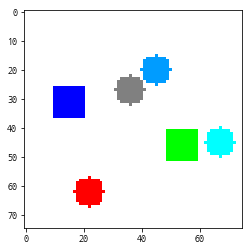

In [12]:
display_image(rel_train[20])

In [21]:
##setting hyper-parameters
args = dict()
args['batch_size'] = 64
args['epoches'] = 50

In [14]:
model = RN_Model(args)
#parameter initialozation
model.collect_params().initialize(ctx=ctx)

In [15]:
#set optimizer
trainer = gluon.Trainer(model.collect_params(),optimizer='adam',optimizer_params={'learning_rate':0.0001})

In [16]:
#define loss function
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [17]:
# prepare coord tensor
def cvt_coord(i):
    return [(i/5-2)/2., (i%5-2)/2.]

In [18]:
def cvt_data_axis(data):
    img = [e[0] for e in data]
    qst = [e[1] for e in data]
    ans = [e[2] for e in data]
    return (img,qst,ans)

In [19]:
def ndarray_conv(data, i,bs):
    img = F.array(np.asarray(data[0][bs*i:bs*(i+1)]))
    qst = F.array(np.asarray(data[1][bs*i:bs*(i+1)]))
    ans = F.array(np.asarray(data[2][bs*i:bs*(i+1)]))

    return img, qst, ans

In [20]:
#Define Evaluation metric
def evaluate_accuracy(data,  model, ctx):
    data_conv = cvt_data_axis(data)
    acc = mx.metric.Accuracy()
    accuracy_mat = []
    for batch_idx in range(len(data) // (args['batch_size'])):
        input_img, input_qst, label = ndarray_conv(data_conv,batch_idx,args['batch_size'])
        input_img = input_img.as_in_context(ctx)
        input_qst = input_qst.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = model(input_img,input_qst)
        predictions = nd.argmax(output,axis=1)
        acc.update(preds=predictions, labels=label)
        accuracy_mat.append(acc.get()[1])
    accuracy = sum(accuracy_mat) / len(accuracy_mat)
    return accuracy

In [22]:
rel_loss = list()
norel_loss =  list()
rel_acc = list()
noel_acc = list()
for epoch in tnrange(args['epoches'], desc="epoches"):
    cumulative_rel_loss = 0.0
    cumulative_norel_loss = 0.0
    
    input_rel_train = rel_train.copy()
    input_norel_train = norel_train.copy()
    
    #shuffle data
    random.shuffle(input_rel_train)
    random.shuffle(input_norel_train)
    
    rel = cvt_data_axis(input_rel_train)
    norel = cvt_data_axis(input_norel_train)
    
    #for batch_idx in tqdm(range(len(rel[0]) // (args['batch_size'] * 4))):
    for batch_idx in range(len(rel[0]) // (args['batch_size']*GPU_COUNT)):
        input_rel_img, input_rel_qst, rel_label = ndarray_conv(rel,batch_idx,args['batch_size']*GPU_COUNT)
        
        #data split
        input_rel_img = gluon.utils.split_and_load(input_rel_img,ctx)
        input_rel_qst = gluon.utils.split_and_load(input_rel_qst,ctx)
        rel_label = gluon.utils.split_and_load(rel_label,ctx)
        coord_tensor = F.zeros((args['batch_size'] * GPU_COUNT, 25, 2))
        coord_tensor = gluon.utils.split_and_load(coord_tensor,ctx)
        with autograd.record():
            rel_losses = [loss(model(X,Y),Z) for X, Y, Z in zip(input_rel_img,input_rel_qst,rel_label)]
        for l in rel_losses:
            l.backward()
        trainer.step(args['batch_size']*GPU_COUNT)
        for l in rel_losses:
            cumulative_rel_loss += nd.sum(l).asscalar()

        
        input_norel_img, input_norel_qst, norel_label = ndarray_conv(norel,batch_idx,args['batch_size']*GPU_COUNT)  
        
        #data split
        input_norel_img = gluon.utils.split_and_load(input_norel_img,ctx)
        input_norel_qst = gluon.utils.split_and_load(input_norel_qst,ctx)
        norel_label = gluon.utils.split_and_load(norel_label,ctx)
        with autograd.record():
            norel_losses = [loss(model(X,Y),Z) for X, Y, Z in zip(input_norel_img,input_norel_qst,norel_label)]
        for l in norel_losses:
            l.backward()
        trainer.step(args['batch_size']*GPU_COUNT)
        for l in norel_losses:
            cumulative_norel_loss += nd.sum(l).asscalar()
            
    rel_accuracy = evaluate_accuracy(rel_test, model, mx.gpu(0))
    norel_accuracy = evaluate_accuracy(norel_test, model, mx.gpu(0))
    if(epoch % 10 == 0):
        print("Epoch {e}. rel_Loss: {rl} norel_Loss: {nrl} rel_ACC: {rl_acc} norel_ACC: {nrl_acc}".format(e=epoch+1, rl=cumulative_rel_loss/(len(rel[0]) // args['batch_size'])
                                                                                                      , nrl=cumulative_norel_loss/ (len(rel[0]) // args['batch_size']), rl_acc=rel_accuracy,nrl_acc=norel_accuracy))
    rel_loss.append(cumulative_rel_loss/(len(rel[0]) // args['batch_size']))
    norel_loss.append(cumulative_norel_loss/ (len(rel[0]) // args['batch_size']))
    rel_acc.append(rel_accuracy)
    noel_acc.append(norel_accuracy)

Epoch 1. rel_Loss: 65.59978985428265 norel_Loss: 48.43851771687932 rel_ACC: 0.6335886654895776 norel_ACC: 0.531717268778355
Epoch 11. rel_Loss: 35.32214403183611 norel_Loss: 40.883301130079275 rel_ACC: 0.6890855608103651 norel_ACC: 0.6301970814786927
Epoch 21. rel_Loss: 29.754591378100475 norel_Loss: 14.331605505117944 rel_ACC: 0.7713105971169344 norel_ACC: 0.9355275518894776
Epoch 31. rel_Loss: 15.722484124244078 norel_Loss: 0.49319553292071056 rel_ACC: 0.8700308683217102 norel_ACC: 0.9928328658339487
Epoch 41. rel_Loss: 10.001781542732543 norel_Loss: 0.2025043380795119 rel_ACC: 0.8825515074252718 norel_ACC: 0.9941643496081265



In [23]:
import seaborn as sns
import collections
perf_metric = collections.OrderedDict()

In [26]:
perf_metric['epoch'] = np.arange(args['epoches'])+1
perf_metric['rel_loss'] = np.array(rel_loss)
perf_metric['no_rel_loss'] =np.array(norel_loss)
perf_metric['rel_acc'] = np.array(rel_acc)
perf_metric['no_rel_acc'] = np.array(noel_acc)

In [27]:
import pandas as pd
perf_metric = pd.DataFrame(perf_metric)

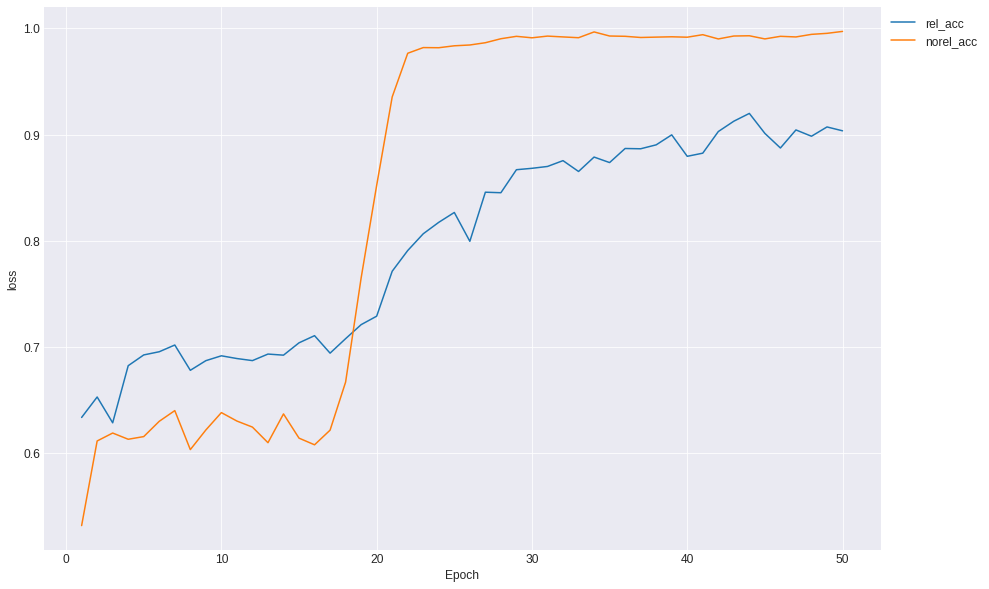

In [29]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,10))
plt.xlabel("Epoch")
plt.ylabel("loss")

plt.plot(np.arange(args['epoches'])+1,  np.array(rel_acc),label="rel_acc")
plt.plot(np.arange(args['epoches'])+1, np.array(noel_acc),label="norel_acc")
plt.legend(bbox_to_anchor=(1, 1), loc=2,)
plt.show()

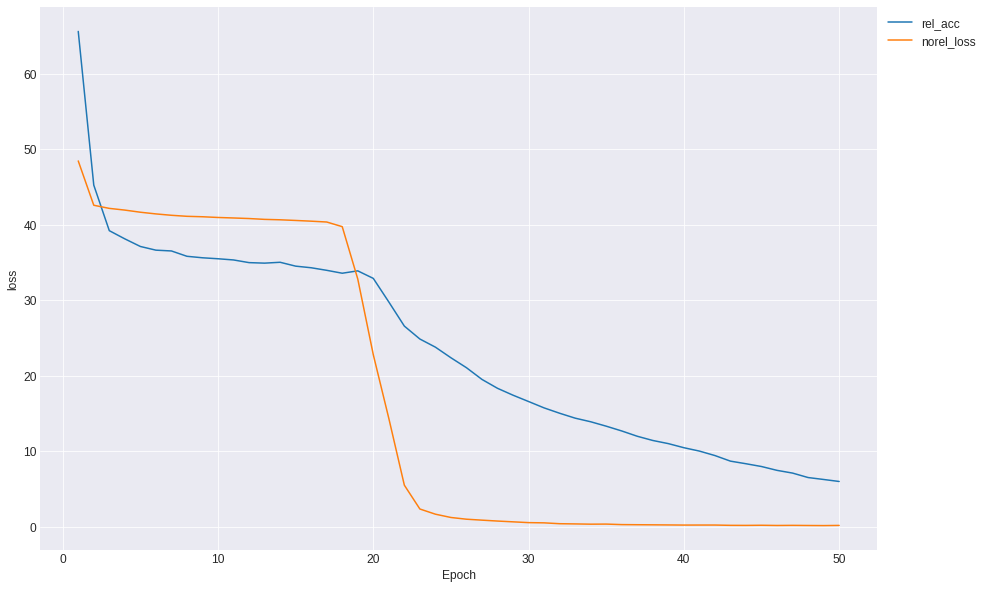

In [31]:
plt.rcParams.update({'font.size': 12})
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.figure(figsize=(15,10))
plt.xlabel("Epoch")
plt.ylabel("loss")

plt.plot(np.arange(args['epoches'])+1,  np.array(rel_loss),label="rel_acc")
plt.plot(np.arange(args['epoches'])+1, np.array(norel_loss),label="norel_loss")
plt.legend(bbox_to_anchor=(1, 1), loc=2,)
plt.show()